# Objekterkennung mit einem CNN

Testobjekterkennung mit einem CNN. Dazu wird der Datensatz "Dog und Cat Detection" verdendet. Dieser enthält Bildern von Hunde und Katzen mit entsprechenden Bounding Boxes.

Datensatzquelle: https://www.kaggle.com/andrewmvd/dog-and-cat-detection

In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2

## Daten

In "annotations" sind XML-Dateien mit Bounding-Box-Infos
Setzen der Pfade:

In [3]:
annot_dir = "D:/Studium_Programme/cats/catdog_detect/annotations"
image_dir = "D:/Studium_Programme/cats/catdog_detect/images"

Test, ob die Dateien gefunden werden:

In [4]:
annot_files = os.listdir(annot_dir)
image_files = os.listdir(image_dir)

print('annot:', len(annot_files))
print('images:', len(image_files))

annot: 3686
images: 3686


Testweise Ausgabe der Dateinamen

In [5]:
image_files[:5]

['Cats_Test0.png',
 'Cats_Test1.png',
 'Cats_Test10.png',
 'Cats_Test100.png',
 'Cats_Test1000.png']

In [6]:
annot_files[:5]

['Cats_Test0.xml',
 'Cats_Test1.xml',
 'Cats_Test10.xml',
 'Cats_Test100.xml',
 'Cats_Test1000.xml']

## Parsing

Definierung von Hilfsfunktionen

In [8]:
def parse_xml(fp):
    obj = {}
    tree = ET.parse(fp)
    root = tree.getroot()
    for x in root:
        if x.tag == 'object':
            for xx in x:
                if xx.tag == 'name':
                    obj['name'] = xx.text
                elif xx.tag == 'bndbox':
                    box = []
                    for xxx in xx:
                        box.append(float(xxx.text))
                    obj['bbox'] = box
                elif xx.tag == 'occluded':
                    obj['occluded'] = int(xx.text)
                elif xx.tag == 'difficult':
                    obj['difficult'] = int(xx.text)
        elif x.tag == 'filename':
            obj['filename'] = x.text
        elif x.tag == 'size':
            size =  []
            for xx in x:
                size.append(int(xx.text))
            obj['size'] = size
    return obj

def plot_bbox(box, c='red'):
    x1, y1, x2, y2 = map(int, box)
    plt.vlines(x1, y1, y2, color=c)
    plt.vlines(x2, y1, y2, color=c)
    plt.hlines(y1, x1, x2, color=c)
    plt.hlines(y2, x1, x2, color=c)
    
def load_sample(xml_fp):
    obj = parse_xml(os.path.join(annot_dir, xml_fp))
    img_fp = os.path.join(image_dir, obj['filename'])
    assert os.path.exists(img_fp)
    img =  cv2.imread(img_fp)[..., ::-1]
    
    return img, obj

Testausgabe eines Bildes und einer Bounding Box

<class 'numpy.ndarray'>


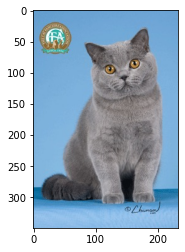

In [11]:
img, ann = load_sample(os.listdir(annot_dir)[0])
print(type(img))
plt.imshow(img)

In [12]:
ann

{'filename': 'Cats_Test0.png',
 'size': [233, 350, 3],
 'name': 'cat',
 'occluded': 0,
 'difficult': 0,
 'bbox': [83.0, 29.0, 197.0, 142.0]}

Skalierung des Bildes mit dem cv2 Paket auf 150X150

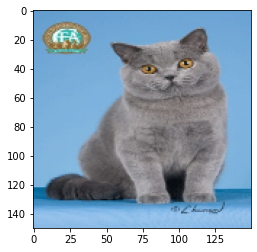

In [14]:
img2 = cv2.resize(img, (150, 150))
plt.imshow(img2)

Randomisiertes Beispielbild mit Bounding Box

[49.5, 29.191616766467067, 94.5, 97.45508982035928]


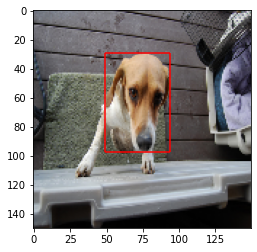

In [20]:
#daten laden
xml_fp = random.sample(os.listdir(annot_dir), 1)[0]
img, ann = load_sample(xml_fp)
#Bildgröße ändern
img2 = cv2.resize(img, (150,150))
#bbox größe ändern
bbox = ann['bbox']
size = ann['size']
bbox[0] = bbox[0] / size[0]*150
bbox[1] = bbox[1] / size[1]*150
bbox[2] = bbox[2] / size[0]*150
bbox[3] = bbox[3] / size[1]*150

#bbox Koordinaten ausgeben
print(bbox)

#bild und bbox zeichnen
plt.imshow(img2)
plot_bbox(bbox)


## Daten transformieren

Skalieren der Bilder auf das Format 150x150 und normalisieren der Werte auf [0, 1]

Neben den vier Koordinaten der Bounding Boxes müssen noch 2 Klassen hinzugefügt werden 
0 = dog
1 = cat

In [21]:
data_x = []
data_y = []

In [22]:
for s in os.listdir(annot_dir):
    img, ann = load_sample(s)    
    size = ann['size']
    bbox = ann['bbox']
    
    # BBox-Daten auf [0, 1] normalisieren
    bbox[0] /= size[0]
    bbox[2] /= size[0]
    bbox[1] /= size[1]
    bbox[3] /= size[1]
    
    # Bilddaten skalieren und normalisieren
    img2 = cv2.resize(img, (150,150))
    img2 = img2 / 255.0
    
    # Klasse hinzufügen (0 = dog, 1 = cat)
    bbox.append(float(ann['name'] == 'cat'))
    data_x.append(img2)
    data_y.append(bbox)


In [23]:
data_x[0].shape

(150, 150, 3)

## Daten aufteilen 

Aufteilen der Daten in Test und Traningsdaten

In [26]:
train_x = np.array(data_x[:2800])
train_y = np.array(data_y[:2800])

test_x = np.array(data_x[2800:])
test_y = np.array(data_y[2800:])

Datensichtung

In [28]:
train_x.shape

(2800, 150, 150, 3)

In [29]:
data_y[:3]

[[0.3562231759656652,
  0.08285714285714285,
  0.8454935622317596,
  0.4057142857142857,
  1.0],
 [0.256, 0.044, 0.48, 0.444, 0.0],
 [0.314, 0.14933333333333335, 0.528, 0.30933333333333335, 0.0]]

In [30]:
data_x[0]

array([[[0.39215686, 0.61960784, 0.80784314],
        [0.39215686, 0.61960784, 0.80784314],
        [0.39215686, 0.61960784, 0.80784314],
        ...,
        [0.41568627, 0.63529412, 0.82745098],
        [0.41568627, 0.63529412, 0.82745098],
        [0.41568627, 0.63529412, 0.82745098]],

       [[0.38823529, 0.61568627, 0.80392157],
        [0.38823529, 0.61568627, 0.80392157],
        [0.38823529, 0.61568627, 0.80392157],
        ...,
        [0.41568627, 0.63529412, 0.82745098],
        [0.41568627, 0.63529412, 0.82745098],
        [0.41568627, 0.63529412, 0.82745098]],

       [[0.39215686, 0.61960784, 0.80784314],
        [0.39607843, 0.62352941, 0.81176471],
        [0.39607843, 0.62352941, 0.81176471],
        ...,
        [0.41568627, 0.63529412, 0.82745098],
        [0.41568627, 0.63529412, 0.82745098],
        [0.41176471, 0.63137255, 0.82352941]],

       ...,

       [[0.5372549 , 0.72941176, 0.89803922],
        [0.53333333, 0.7254902 , 0.89411765],
        [0.54509804, 0

## CNN NETZ

Erzeugen des CNN Netzes

In [96]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

#Erstellen eines NN mit 4 Conv und 4 max pooling Schichten. 
#Eine Flatten Schicht und 2 Dense Schichten
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150,150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='linear'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 15, 15, 128)      

In [97]:
#Lossfunktion und optimser definieren
model.compile(loss='mean_squared_error',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [98]:
#Modell mit 50 epochen trainieren
history = model.fit(train_x, train_y, 
                    epochs=50,
                    validation_data=(test_x, test_y))

Epoch 1/50
88/88 [==============================] - 2s 28ms/step - loss: 0.0742 - acc: 0.4689 - val_loss: 0.0830 - val_acc: 0.4898
Epoch 2/50
88/88 [==============================] - 2s 25ms/step - loss: 0.0637 - acc: 0.4807 - val_loss: 0.0621 - val_acc: 0.4955
Epoch 3/50
88/88 [==============================] - 2s 26ms/step - loss: 0.0583 - acc: 0.4893 - val_loss: 0.0654 - val_acc: 0.4966
Epoch 4/50
88/88 [==============================] - 2s 27ms/step - loss: 0.0536 - acc: 0.4982 - val_loss: 0.0584 - val_acc: 0.5655
Epoch 5/50
88/88 [==============================] - 2s 27ms/step - loss: 0.0498 - acc: 0.5104 - val_loss: 0.0505 - val_acc: 0.5248
Epoch 6/50
88/88 [==============================] - 2s 27ms/step - loss: 0.0466 - acc: 0.5314 - val_loss: 0.0630 - val_acc: 0.5835
Epoch 7/50
88/88 [==============================] - 2s 27ms/step - loss: 0.0433 - acc: 0.5507 - val_loss: 0.0525 - val_acc: 0.5226
Epoch 8/50
88/88 [==============================] - 2s 25ms/step - loss: 0.0401 - a

## Evaluation

In [99]:
pred = model.predict(test_x)

Funktion, die das i-te Testbild mit Bounding Boxes zeigt

In [100]:
def show_result(i):
    img = test_x[i]
    bbox = test_y[i, :4]
    pred_bbox = pred[i,:4]

    print('class:', test_y[i, 4], ' predicted:', pred[i, 4])
    print('org bbox: ', bbox)
    print('pred bbox:', pred_bbox)
    print('IMAGE BLUE=CORRECT RED=PREDICTED')

    plt.imshow(img)
    plot_bbox(pred_bbox[:4]*150)
    plot_bbox(bbox[:4]*150, c='blue')

class: 0.0  predicted: 0.48365346
org bbox:  [0.43666667 0.09333333 0.73333333 0.54222222]
pred bbox: [0.22927396 0.07551135 0.71745825 0.6564204 ]
IMAGE BLUE=CORRECT RED=PREDICTED


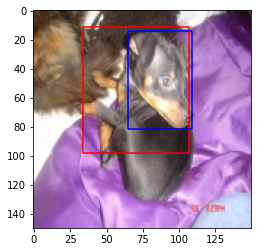

In [101]:
#Show result mit Bild 20
show_result(20)

class: 0.0  predicted: 0.21853031
org bbox:  [0.53       0.21866667 0.698      0.472     ]
pred bbox: [0.439137   0.10360117 0.61916804 0.37614486]
IMAGE BLUE=CORRECT RED=PREDICTED


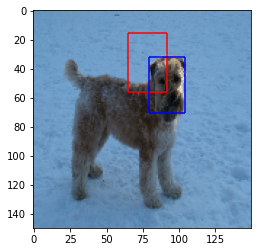

In [102]:
#Show result mit Bild 25
show_result(25)

In [103]:
def plot_bb(ax, box, c='red'):
    x1, y1, x2, y2 = map(int, box)
    ax.vlines(x1, y1, y2, color=c)
    ax.vlines(x2, y1, y2, color=c)
    ax.hlines(y1, x1, x2, color=c)
    ax.hlines(y2, x1, x2, color=c)

p_rows = 3
p_cols = 2
    
def show_results(i):
    fig, ax = plt.subplots(p_rows, p_cols)
    fig.tight_layout()
    #fig.figsize(3, 3)
    
    j = 0
    for a in ax.flat:
        img = test_x[i+j]
        bbox = test_y[i+j, :4]
        pred_bbox = pred[i+j,:4]

        a.imshow(img)
        a.set_title(f'{i}: y={test_y[i+j,4]:.0f} pr={pred[i+j,4]:.1f}')
        plot_bb(a, pred_bbox[:4]*150)
        plot_bb(a, bbox[:4]*150, c='blue')
        j += 1

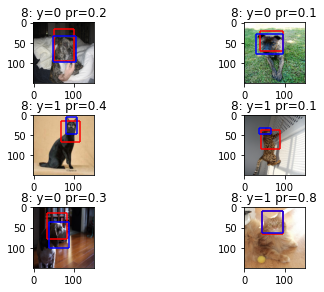

In [104]:
show_results(8)

## Neue Bilder 

Neue Bilder welche nicht im Datenset vorhanden sind werden getestet.

In [105]:
test_dir = "D:/Studium_Programme/cats/catdog_detect/eigene"
test_files = os.listdir(test_dir)
print(test_files)

['20220323_010251581_iOS.jpg', 'download.jpg', 'download1.jpg', 'IMG_3075.jpg', 'IMG_7159.jpg', 'Screenshot 2022-04-11 000509.png']


In [106]:
def process_test(i):
    img =  cv2.imread(os.path.join(test_dir, test_files[i]))[..., ::-1]
    img2 = cv2.resize(img, (150, 150))
    img2 = img2 / 255.0
    p = model.predict(img2.reshape(-1,150,150,3))[0]
    print(p, '\n=> prediction:', "cat" if p[4] > .5 else "dog")
    plt.imshow(img2)
    plot_bbox(p[:4]*150)

[ 0.31010222  0.17006578  0.719134    0.5948451  -0.06131412] 
=> prediction: dog


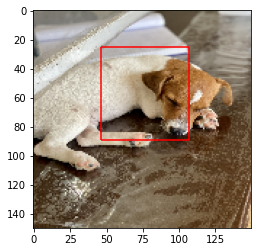

In [107]:
process_test(0)

[0.32707325 0.2283384  0.67419744 0.619642   0.48278496] 
=> prediction: dog


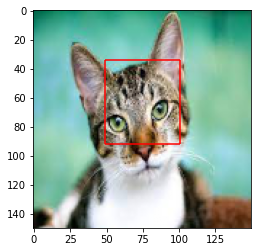

In [108]:
process_test(1)

[0.20706968 0.09635876 0.48941666 0.6357924  0.24480297] 
=> prediction: dog


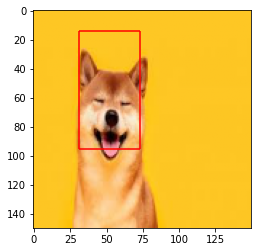

In [109]:
process_test(2)

[0.21490683 0.13127722 0.512681   0.5098545  0.13960901] 
=> prediction: dog


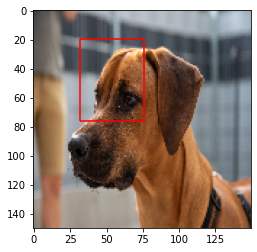

In [110]:
process_test(3)

[ 0.31502938  0.10390593  0.5120374   0.45141613 -0.09952725] 
=> prediction: dog


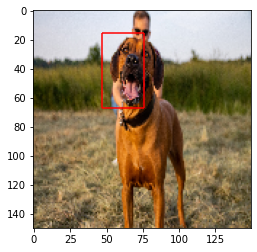

In [111]:
process_test(4)

[0.17677918 0.02474461 0.65917516 0.51144165 0.662457  ] 
=> prediction: cat


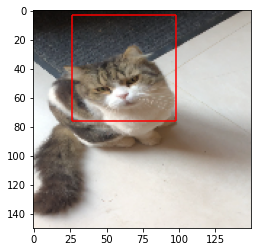

In [112]:
process_test(5)